In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from scipy.optimize import curve_fit
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import copy

## Load data to fit "ground truth" curves

In [3]:
bat_dict = pickle.load(open('/content/bat_dict_small.pkl', 'rb'))

In [2]:
def func(x, a, b, c):
    #return np.exp(a/temps)*x**b + c
    return np.exp(a)*x**b + c

In [4]:
params = []
cycle_lives = []
#pred_cycle_lives = []
for id in bat_dict.keys():
    bat = bat_dict[id]
    #temps = np.mean(bat['summary']['Tavg'][1:cutoff])+273
    Y = 1-bat['summary']['QD'][1:]/1.1
    length = len(bat['summary']['QD'][1:])
    x = np.arange(1,length+1)
    param = curve_fit(func, x, Y, maxfev = 4000)[0]

    alpha = param[0]
    beta = param[1]
    gamma = param[2]
    params.append([alpha,beta,gamma])

    cycle_lives.append(bat["cycle_life"][0])
    #pred_cycle_lives.append([np.power(np.exp(-alpha)*(0.2-gamma),1/beta)])
params = np.array(params)
cycle_lives = np.array(cycle_lives)
#pred_cycle_lives = np.array(pred_cycle_lives)

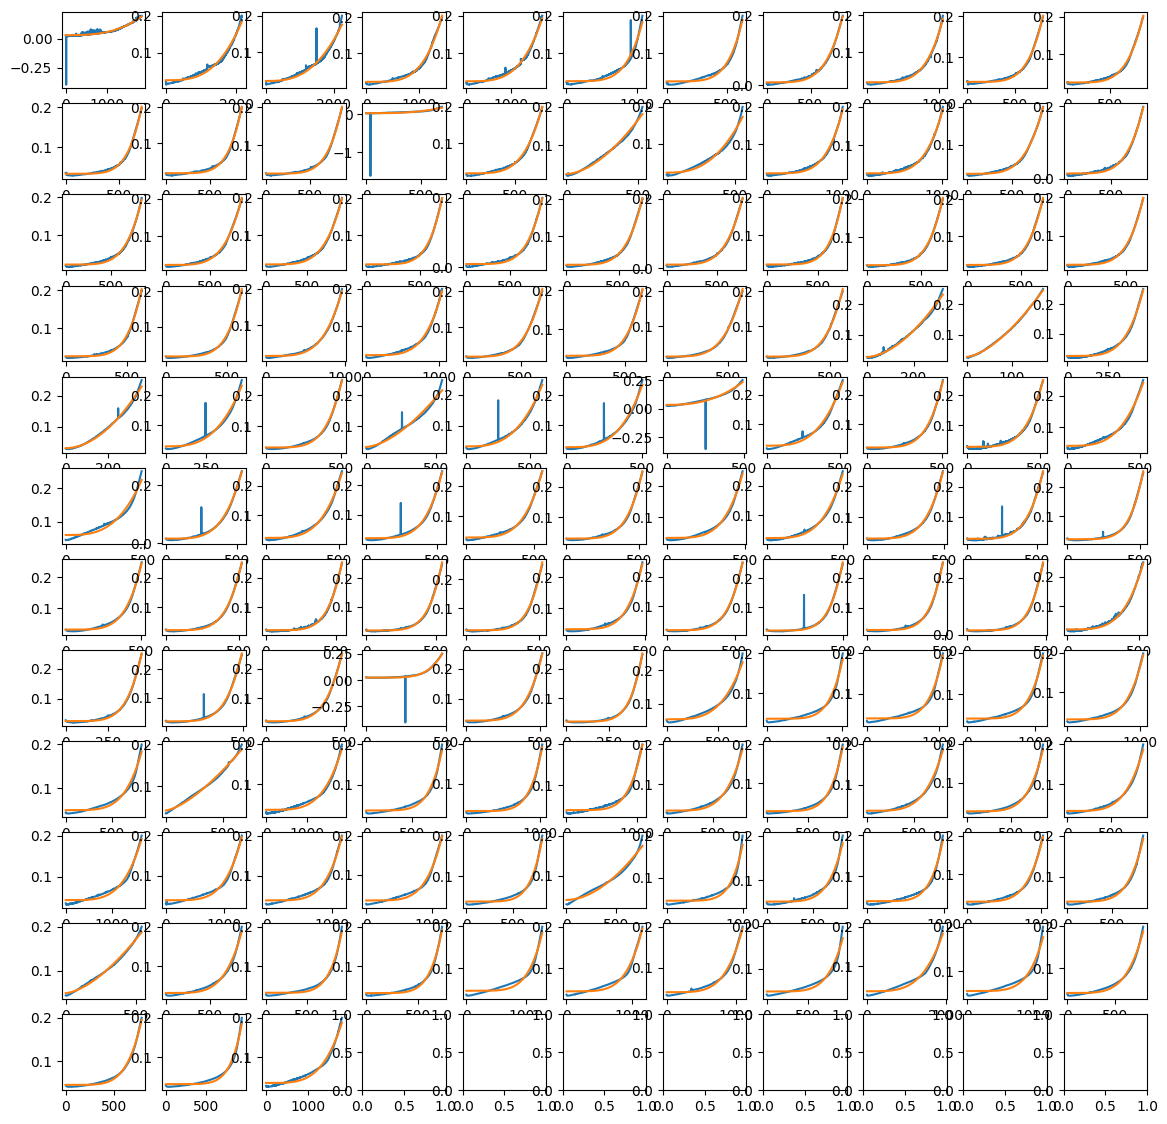

In [5]:
# visualize curve fits
fig,axs=plt.subplots(nrows=12,ncols=11,figsize=(14,14))
for ix,id in enumerate(bat_dict.keys()):
    ax = axs[int(ix/11)][ix%11]
    length = len(bat_dict[id]['summary']['QD'][1:])
    x = np.arange(1,length+1)
    Y = 1-bat_dict[id]['summary']['QD'][1:]/1.1
    ax.plot(x, Y)

    alpha = params[ix][0]
    beta = params[ix][1]
    gamma = params[ix][2]
    ax.plot(x, func(x,alpha,beta,gamma), linestyle="-")

## Load data for predictive model

In [7]:
# features4 uses Severson interpolated data AND takes the log of all statistical features
# can try features3, which still uses Severson data but without the log of min, mean, skew kurtosis
data = np.loadtxt('/content/features4.csv',delimiter=',',skiprows=1) # skip row for column names

In [8]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122])

In [9]:
# logVar, logMean, logMin, logSkew, logKurtosis
x_train = data[:,[1,2,3,18,19]][train_ind]
y_train = params[train_ind]
life_train = cycle_lives[train_ind]

x_test = data[:,[1,2,3,18,19]][test_ind]
y_test = params[test_ind]
life_test = cycle_lives[test_ind]

x_stest = data[:,[1,2,3,18,19]][secondary_ind]
y_stest = params[secondary_ind]
life_stest = cycle_lives[secondary_ind]

In [10]:
train = TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train),torch.Tensor(life_train))
test = TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test),torch.Tensor(life_test))
stest = TensorDataset(torch.Tensor(x_stest),torch.Tensor(y_stest),torch.Tensor(life_stest))

In [139]:
class AttentionModel(torch.nn.Module):
    def __init__(self, d_model, feat_dim, n_cycle, vdim=1, num_heads=1, attn_model="softmax", beta=1, skip_connect=0):
        super(AttentionModel, self).__init__()
        '''d_model: embedding dimension; can be chosen independently of input data dimensions
           feat_dim: number of features in a cycle
           n_cycle: number of "cycles" outputted by the encoder / number of tokens, each of which has feat_dim features
           vdim: dimension of output, 1 for our regression problem
           num_heads: default 1
           attn_model: default softmax; code also supports batch normalized attention with keyword "batch_norm"
           beta: if using batch normalized attention, beta is the weight placed on the mean
           skip_connect: whether or not to add a skip connection. If 0, no skip connection. If 1, H=AV+B where B
           is a trainable projection of the input X. If 2, H=AV+V'''
        assert d_model % num_heads == 0, "Embedding dimension (d_model) must be divisible by number of attention heads (num_heads)."

        self.W_q = nn.Linear(feat_dim, d_model)
        self.W_k = nn.Linear(feat_dim, d_model)
        self.W_v = nn.Linear(feat_dim, vdim)
        self.W_b = nn.Linear(feat_dim, vdim)

        #self.create_output = nn.Linear(n_cycle,1) # final linear layer to collapse output

        self.d_model = d_model
        self.vdim = vdim
        self.num_heads = num_heads
        #self.head_dim = d_model // num_heads

        self.attn_model = attn_model
        self.beta = beta
        self.skip_connect = skip_connect

    def scaled_dot_product_attention(self, Q, K, V, B):
        '''softmax attention'''
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model // self.num_heads)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, n_cycle, n_cycle)
        output = torch.matmul(attn_probs, V) # dimensionality (batch size, n_cycle, vdim)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output

    def batch_normalized_attention(self, Q, K, V, B):
        '''batch normalized attention'''
        mu = torch.mean(K,0)
        s = torch.std(K,0,correction=0)
        attn_scores = torch.matmul(torch.mul(Q-self.beta*mu,s), torch.mul(K-self.beta*mu,s).transpose(-2,-1)) / math.sqrt(self.d_model)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, batch size)
        output = torch.matmul(attn_probs, V)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output

    def forward(self, X):
        if len(X.size()) < 3:
            X = X[...,None] # add a feature dimension if there is none
        Q = self.W_q(X) # create query matrix, dimensionality (batch size, n_cycle, d_model)
        K = self.W_k(X) # create key matrix, dimensionality (batch size, n_cycle, d_model)
        V = self.W_v(X) # create value matrix, dimensionality (batch size, n_cycle, vdim)
        B = self.W_b(X) # create matrix for skip connection, dimensionality (batch size, n_cycle, vdim)

        # replaced final linear layer with just an averaging layer (gave better results earlier, can try putting linear layer back)
        if self.attn_model=="softmax": attn_output = self.scaled_dot_product_attention(Q, K, V, B)
        elif self.attn_model=="batch_norm": attn_output = self.batch_normalized_attention(Q, K, V, B)
        # attn_output has dimensionality (batch_size, n_cycle, vdim)
        output = torch.mean(attn_output.transpose(-2,-1),dim=-1) # dimensionality (batch_size, vdim)
        #output = self.create_output(attn_output.transpose(-2,-1)) # dimensionality (batch size, 1, 1)
        return output

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## First round of training (calc loss w/ model parameters)

In [140]:
d_model = 2
feat_dim = 1
n_cycle = np.shape(x_train)[1]
attn_model = "softmax"
skip_connect = 0
nepoch = 500
lr = 1e-3
batch_size = 1

n = 10 # number of points at which to compare predicted curve with fitted curve
x = torch.Tensor(np.arange(1,n))
weights = torch.tensor([1/32,1/4,1/0.02]) # used to normalize magnitudes of parameters

In [141]:
class weighted_MSELoss(nn.Module):
    '''calculates MSE of scaled/normalized parameters'''
    def __init__(self):
        super().__init__()
    def forward(self,inputs,targets,weights):
        return torch.mean( torch.mul(((inputs - targets)**2 ), weights) )

In [142]:
model = AttentionModel(d_model=d_model,feat_dim=feat_dim,n_cycle=n_cycle,vdim=3,attn_model=attn_model,skip_connect=skip_connect)
criterion = weighted_MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label, true_life = batch
        output = model(train_input.to(device))

        fit_curve = torch.exp(train_label[:,0])*torch.pow(x*(true_life/n),train_label[:,1])+train_label[:,2]
        pred_curve = torch.exp(output[:,0])*torch.pow(x*(true_life/n),output[:,1])+output[:,2]
        #loss = criterion(fit_curve,pred_curve,torch.Tensor(np.ones(len(x))))

        # calc loss as a linear combination of difference between curves and MSE loss of parameters
        loss = criterion(fit_curve,pred_curve,torch.Tensor(np.ones(len(x)))) + 0.75*criterion(output,train_label,weights)
        #loss = criterion(output, train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label, true_life = cell
        test_output = model(test_input.to(device))
        fit_curve = torch.exp(test_label[:,0])*torch.pow(x*(true_life/n),test_label[:,1])+test_label[:,2]
        pred_curve = torch.exp(test_output[:,0])*torch.pow(x*(true_life/n),test_output[:,1])+test_output[:,2]
        test_loss = criterion(fit_curve,pred_curve,torch.Tensor(np.ones(len(x))))
        #test_loss = criterion(test_output, test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label, true_life = cell
        stest_output = model(stest_input.to(device))
        fit_curve = torch.exp(stest_label[:,0])*torch.pow(x*(true_life/n),stest_label[:,1])+stest_label[:,2]
        pred_curve = torch.exp(stest_output[:,0])*torch.pow(x*(true_life/n),stest_output[:,1])+stest_output[:,2]
        stest_loss = criterion(fit_curve,pred_curve,torch.Tensor(np.ones(len(x))))
        #stest_loss = criterion(stest_output, stest_label)

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0:
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

Epochs: 50 | rmse:  2.187 | rmse_test:  0.203 | rmse_stest:  0.277
Epochs: 100 | rmse:  1.377 | rmse_test:  0.142 | rmse_stest:  0.167
Epochs: 150 | rmse:  0.882 | rmse_test:  0.111 | rmse_stest:  0.110
Epochs: 200 | rmse:  0.637 | rmse_test:  0.090 | rmse_stest:  0.080
Epochs: 250 | rmse:  0.589 | rmse_test:  0.076 | rmse_stest:  0.066
Epochs: 300 | rmse:  0.585 | rmse_test:  0.078 | rmse_stest:  0.073
Epochs: 350 | rmse:  0.581 | rmse_test:  0.075 | rmse_stest:  0.076
Epochs: 400 | rmse:  0.579 | rmse_test:  0.071 | rmse_stest:  0.075
Epochs: 450 | rmse:  0.578 | rmse_test:  0.070 | rmse_stest:  0.078
Epochs: 500 | rmse:  0.578 | rmse_test:  0.070 | rmse_stest:  0.082


In [143]:
model(train_input.to(device))

tensor([[-3.4174e+01,  4.6524e+00,  1.6821e-02]], grad_fn=<MeanBackward1>)

In [144]:
output

tensor([[-3.4171e+01,  4.6512e+00,  1.6452e-02]], grad_fn=<MeanBackward1>)

225.0983900198151
255.36276111375898
216.5293181180875


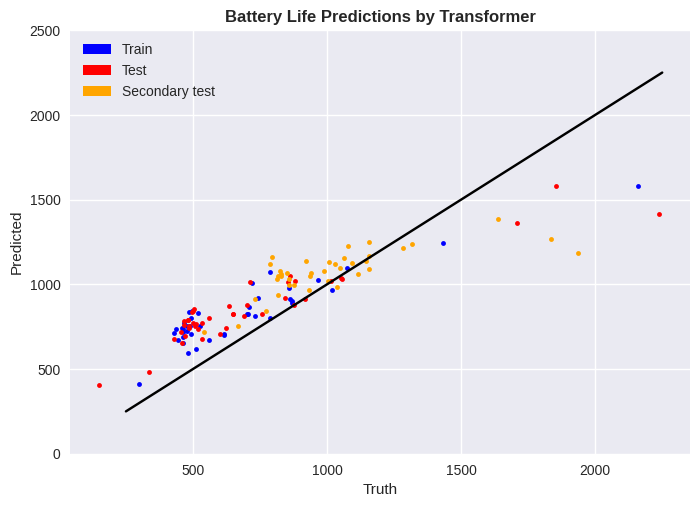

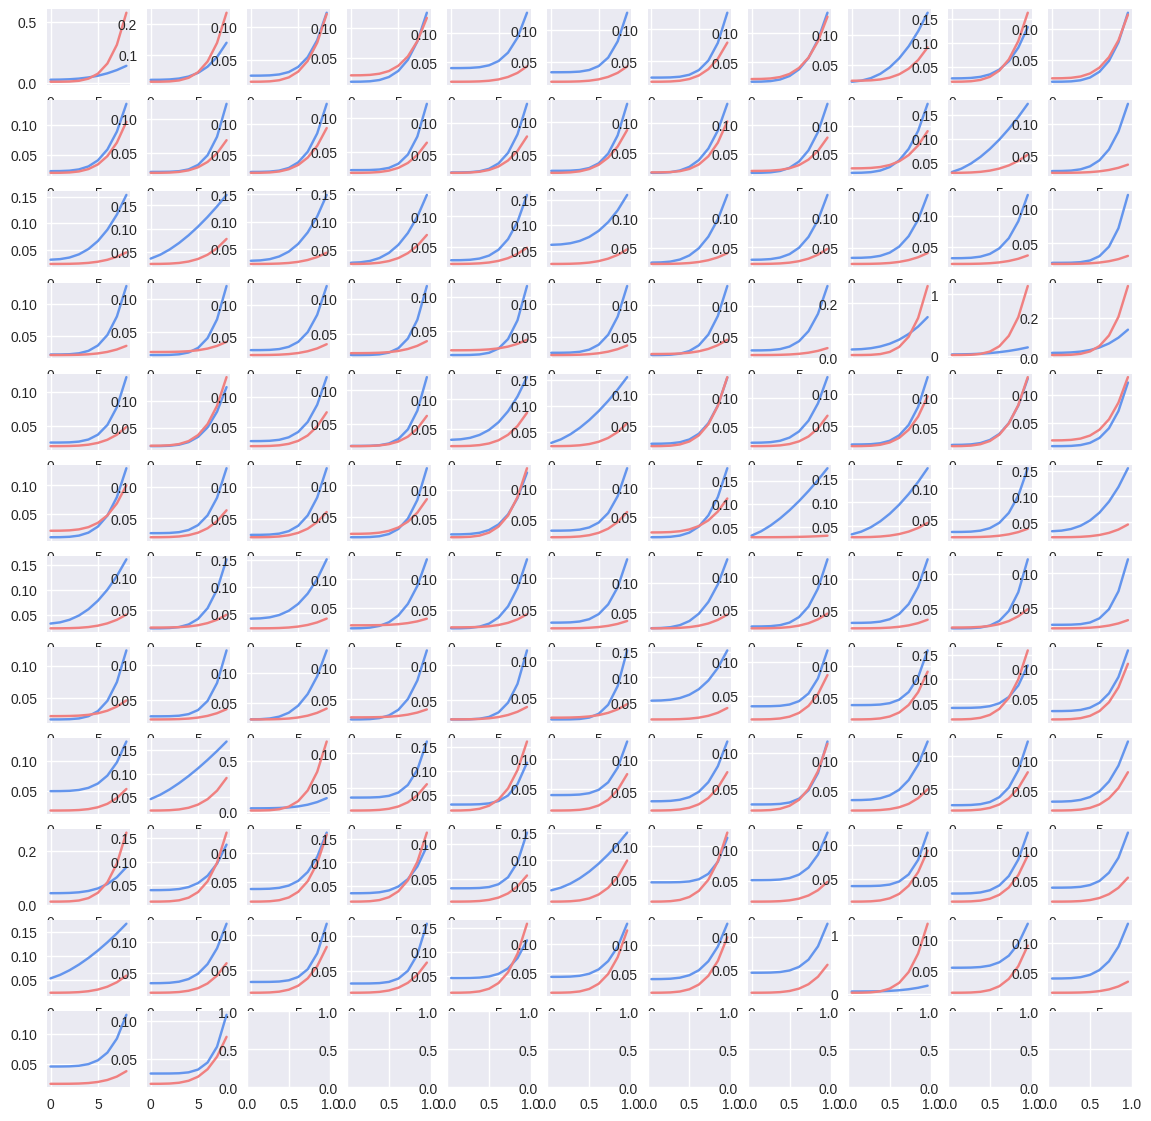

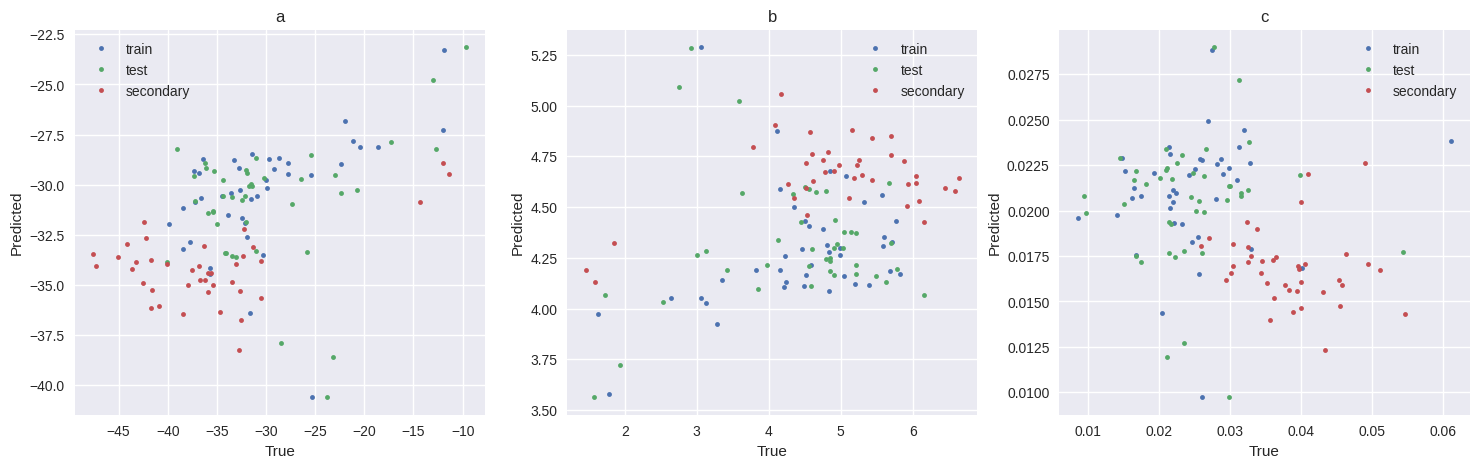

In [145]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch
np.set_printoptions(suppress=True)

fig, ax = plt.subplots()
fig_curve,axs_curve=plt.subplots(nrows=12,ncols=11,figsize=(14,14))

colors = ["blue","red","orange"]
parameter_results = {0:[[], []], 1:[[], []], 2:[[], []]}
ix = 0

for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label, true_life = cell
        pred = model(input[None,:].to(device)).detach().numpy()[0]
        pred_life = np.power(np.exp(-pred[0])*(0.2-pred[2]),1/pred[1])
        #true_life = np.power(np.exp(-label[0])*(0.2-label[2]),1/label[1])
        parameter_results[i][0].append(label.detach().numpy())
        parameter_results[i][1].append(pred)
        predicted.append(pred_life)
        labels.append(true_life[0])

        fit_curve = torch.exp(label[0])*torch.pow(x*(true_life/n),label[1])+label[2]
        pred_curve = np.exp(pred[0])*np.power(x*(true_life/n),pred[1])+pred[2]

        # plot predicted vs. ground truth curves
        ax_curve = axs_curve[int(ix/11)][ix%11]
        ax_curve.plot(fit_curve.detach().numpy(), color="cornflowerblue")
        ax_curve.plot(pred_curve, color="lightcoral")
        ix+=1

    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))
    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

# plot predicted vs. actual cycle lives
ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_ylim([0,2500])
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
plt.show()

# plot predicted vs. ground truth model parameters
for i in range(3):
    parameter_results[i][0] = np.array(parameter_results[i][0])
    parameter_results[i][1] = np.array(parameter_results[i][1])

plt.rcParams["figure.figsize"] = (18, 5)
fig, axs = plt.subplots(1, 3)
for i, title in zip(range(3), ["a", "b", "c"]):
    axs[i].set_title(title)
    for j, lab in zip(range(3), ["train", "test", "secondary"]):
        axs[i].plot(parameter_results[j][0][:, i], parameter_results[j][1][:, i], ".", label = lab)
        axs[i].set_xlabel("True")
        axs[i].set_ylabel("Predicted")
    axs[i].legend()
plt.show()

## Second round of training (calc loss w/ cycle lifetime)

In [146]:
# create a deep copy of model to fine tune
model2 = copy.deepcopy(model)

In [147]:
# low learning rate and many epochs for fine-tuning
lr_fine = 1e-5
optimizer_fine = torch.optim.Adam(model2.parameters(), lr=lr_fine)
nepoch = 3000
criterion = nn.MSELoss().to(device)

In [148]:
# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer_fine.zero_grad()
        train_input, train_label, true_life = batch
        output = model2(train_input.to(device))

        # calculate lifetime using closed-form equation
        pred_life = torch.pow(torch.exp(-output[:,0])*(0.2-output[:,2]),1/output[:,1])
        #true_life = torch.pow(torch.exp(-train_label[:,0])*(0.2-train_label[:,2]),1/train_label[:,1])
        if torch.isnan(pred_life):
            print(output)
            break

        #loss = criterion(output, train_label)
        loss = criterion(pred_life,true_life[:,0])
        total_loss_train += loss.item()

        loss.backward()
        optimizer_fine.step()

    for cell in test_batched:
        test_input, test_label, true_life = cell
        test_output = model2(test_input.to(device))
        #test_loss = criterion(test_output, test_label)
        pred_life = torch.pow(torch.exp(-test_output[:,0])*(0.2-test_output[:,2]),1/test_output[:,1])
        #true_life = torch.pow(torch.exp(-test_label[:,0])*(0.2-test_label[:,2]),1/test_label[:,1])

        test_loss = criterion(pred_life,true_life[:,0])

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label, true_life = cell
        stest_output = model2(stest_input.to(device))
        #stest_loss = criterion(stest_output, stest_label)

        pred_life = torch.pow(torch.exp(-stest_output[:,0])*(0.2-stest_output[:,2]),1/stest_output[:,1])
        #true_life = torch.pow(torch.exp(-stest_label[:,0])*(0.2-stest_label[:,2]),1/stest_label[:,1])

        stest_loss = criterion(pred_life,true_life[:,0])

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%100 == 0:
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

Epochs: 100 | rmse:  187.832 | rmse_test:  231.259 | rmse_stest:  223.265
Epochs: 200 | rmse:  184.558 | rmse_test:  229.363 | rmse_stest:  228.880
Epochs: 300 | rmse:  182.063 | rmse_test:  226.783 | rmse_stest:  228.228
Epochs: 400 | rmse:  179.606 | rmse_test:  223.926 | rmse_stest:  226.238
Epochs: 500 | rmse:  177.176 | rmse_test:  221.020 | rmse_stest:  224.070
Epochs: 600 | rmse:  174.710 | rmse_test:  218.154 | rmse_stest:  222.087
Epochs: 700 | rmse:  172.248 | rmse_test:  215.261 | rmse_stest:  219.957
Epochs: 800 | rmse:  169.874 | rmse_test:  212.444 | rmse_stest:  218.083
Epochs: 900 | rmse:  167.490 | rmse_test:  209.619 | rmse_stest:  216.096
Epochs: 1000 | rmse:  165.182 | rmse_test:  206.885 | rmse_stest:  214.362
Epochs: 1100 | rmse:  162.926 | rmse_test:  204.133 | rmse_stest:  212.471
Epochs: 1200 | rmse:  160.684 | rmse_test:  201.504 | rmse_stest:  210.950
Epochs: 1300 | rmse:  158.476 | rmse_test:  198.861 | rmse_stest:  209.294
Epochs: 1400 | rmse:  156.345 | rm

127.3762624732822
41
41
160.66790265728176
43
43
192.63508485132647
39
39


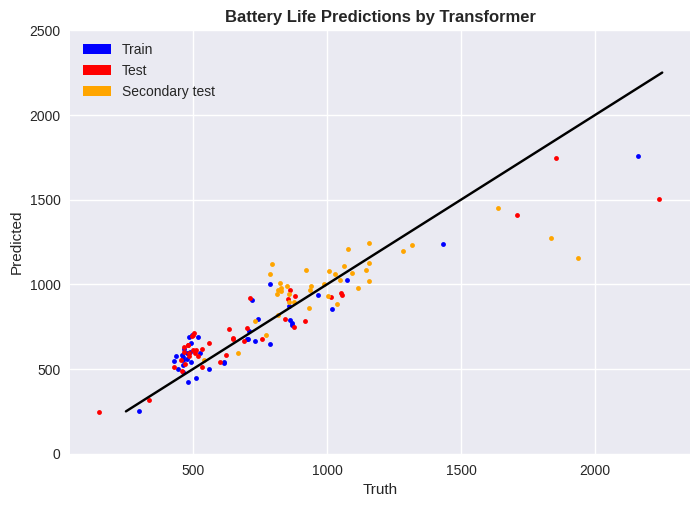

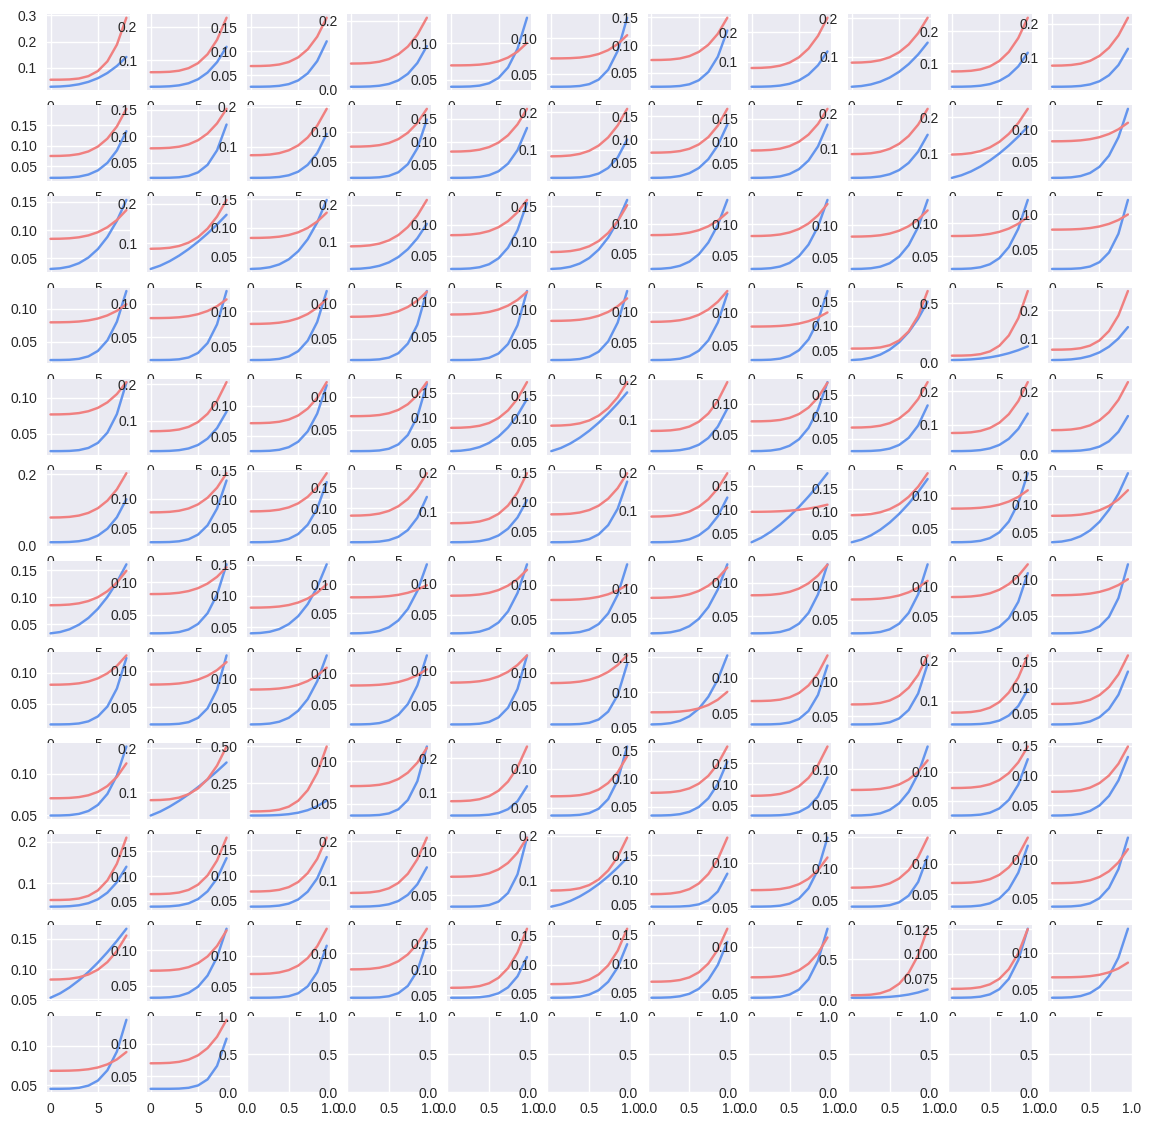

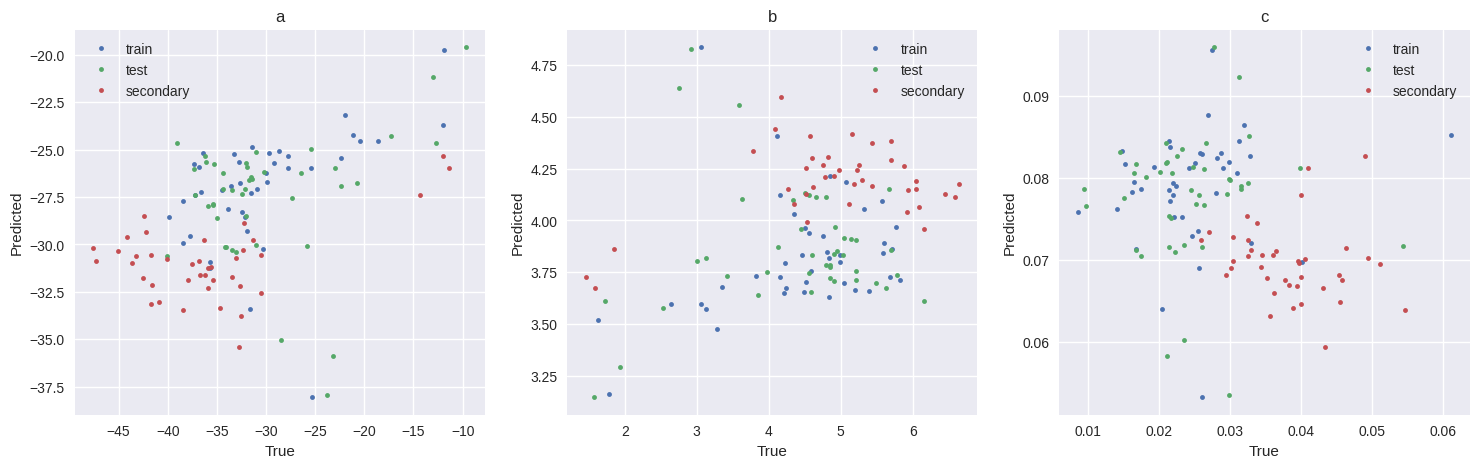

In [149]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch
np.set_printoptions(suppress=True)

fig, ax = plt.subplots()
fig_curve,axs_curve=plt.subplots(nrows=12,ncols=11,figsize=(14,14))

colors = ["blue","red","orange"]
parameter_results = {0:[[], []], 1:[[], []], 2:[[], []]}
ix = 0

for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label, true_life = cell
        pred = model2(input[None,:].to(device)).detach().numpy()[0]
        pred_life = np.power(np.exp(-pred[0])*(0.2-pred[2]),1/pred[1])
        #true_life = np.power(np.exp(-label[0])*(0.2-label[2]),1/label[1])
        parameter_results[i][0].append(label.detach().numpy())
        parameter_results[i][1].append(pred)
        predicted.append(pred_life)
        labels.append(true_life[0])

        fit_curve = torch.exp(label[0])*torch.pow(x*(true_life/n),label[1])+label[2]
        pred_curve = np.exp(pred[0])*np.power(x*(true_life/n),pred[1])+pred[2]

        # plot predicted vs. ground truth curves
        ax_curve = axs_curve[int(ix/11)][ix%11]
        ax_curve.plot(fit_curve.detach().numpy(), color="cornflowerblue")
        ax_curve.plot(pred_curve, color="lightcoral")
        ix+=1

    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))
    ax.plot(labels, predicted, ".",color=colors[i])
    print(len(labels))
    print(len(predicted))
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

# plot predicted vs. actual cycle lives
ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_ylim([0,2500])
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
plt.show()

# plot predicted vs. ground truth model parameters
for i in range(3):
    parameter_results[i][0] = np.array(parameter_results[i][0])
    parameter_results[i][1] = np.array(parameter_results[i][1])

plt.rcParams["figure.figsize"] = (18, 5)
fig, axs = plt.subplots(1, 3)
for i, title in zip(range(3), ["a", "b", "c"]):
    axs[i].set_title(title)
    for j, lab in zip(range(3), ["train", "test", "secondary"]):
        axs[i].plot(parameter_results[j][0][:, i], parameter_results[j][1][:, i], ".", label = lab)
        axs[i].set_xlabel("True")
        axs[i].set_ylabel("Predicted")
    axs[i].legend()
plt.show()

In [154]:
model2.forward(input[None,:].to(device)).detach().numpy()[0]

array([-30.859467  ,   4.177463  ,   0.06990425], dtype=float32)

In [158]:
import shap
# pred = model2.forward(input[None,:].to(device)).detach().numpy()[0]
# explainer = shap.Explainer(labels,np.power(np.exp(-pred[0])*(0.2-pred[2]),1/pred[1]))
input_data = input[None,:].to(device).detach().numpy()[0]
input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)

# Create a SHAP explainer for model2
explainer = shap.Explainer(model2)

# Compute SHAP values for input_tensor
shap_values = explainer.shap_values(input_tensor)


IndexError: ignored

In [ ]:
input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)

# Create a SHAP explainer for model2
explainer = shap.Explainer(model2)

# Compute SHAP values for input_tensor
shap_values = explainer.shap_values(input_tensor)


## **Post Analysis**

In [94]:
import pandas as pd
df = pd.DataFrame(array)

# You can optionally set column names if needed
# For example, if you have meaningful column names for each feature:
column_names = ['Feature1', 'Feature2', 'Feature3']
df.columns = column_names
df.head()

,Feature1,Feature2,Feature3
0,"[tensor(-5.0140), tensor(-1.9585), tensor(-1.9...","[tensor(-25.3704), tensor(3.0643), tensor(0.02...",[tensor(2160.)]
1,"[tensor(-4.4426), tensor(-1.7221), tensor(-1.7...","[tensor(-31.6128), tensor(4.1172), tensor(0.02...",[tensor(1434.)]
2,"[tensor(-4.1789), tensor(-1.5990), tensor(-1.5...","[tensor(-35.7142), tensor(4.8535), tensor(0.02...",[tensor(1074.)]
3,"[tensor(-3.8135), tensor(-1.4176), tensor(-1.4...","[tensor(-32.4773), tensor(4.5533), tensor(0.00...",[tensor(870.)]
4,"[tensor(-4.1469), tensor(-1.6254), tensor(-1.6...","[tensor(-35.6634), tensor(5.0747), tensor(0.04...",[tensor(788.)]


In [95]:
def unpack_and_convert_to_float(tensor):
    if isinstance(tensor, torch.Tensor):
        return [element.item() for element in tensor]
    else:
        return tensor

# Use applymap to apply the unpack_and_convert_to_float function to each element in the DataFrame
df_float = df.applymap(unpack_and_convert_to_float)
df_float

,Feature1,Feature2,Feature3
0,"[-5.0139594078063965, -1.9584566354751587, -1....","[-25.37039566040039, 3.0642755031585693, 0.026...",[2160.0]
1,"[-4.442613124847412, -1.7221492528915405, -1.7...","[-31.612808227539062, 4.117194652557373, 0.020...",[1434.0]
2,"[-4.178877830505371, -1.5989652872085571, -1.5...","[-35.714210510253906, 4.853462219238281, 0.025...",[1074.0]
3,"[-3.813486099243164, -1.4175572395324707, -1.4...","[-32.47725296020508, 4.553297996520996, 0.0086...",[870.0]
4,"[-4.1468963623046875, -1.6254072189331055, -1....","[-35.663448333740234, 5.074744701385498, 0.040...",[788.0]
5,"[-4.017949104309082, -1.5384330749511719, -1.5...","[-38.442264556884766, 5.575802326202393, 0.033...",[719.0]
6,"[-3.9701595306396484, -1.5076872110366821, -1....","[-37.685874938964844, 5.324521064758301, 0.024...",[857.0]
7,"[-3.6199069023132324, -1.3382564783096313, -1....","[-29.89795684814453, 4.230165958404541, 0.0165...",[788.0]
8,"[-3.3503379821777344, -1.1889597177505493, -1....","[-18.6368408203125, 2.6486058235168457, 0.0214...",[559.0]
9,"[-3.938662528991699, -1.4969978332519531, -1.4...","[-31.93189239501953, 4.354547023773193, 0.0255...",[1017.0]


In [104]:
feature_split = pd.DataFrame(df_float['Feature1'].tolist(), columns=['Feature01', 'Feature02', 'Feature03','Feature04', 'Feature05'])
param_split  =  pd.DataFrame(df_float['Feature2'].tolist(), columns=['Alpha', 'Beta', 'Gamma',])
target =  pd.DataFrame(df_float['Feature3'].tolist(), columns=['target'])

df = pd.concat([feature_split, param_split, target], axis=1)

In [110]:
df.head()

,Feature01,Feature02,Feature03,Feature04,Feature05,Alpha,Beta,Gamma,target
0,-5.013959,-1.958457,-1.958457,0.017039,0.000000,-25.370396,3.064276,0.026147,2160.0
1,-4.442613,-1.722149,-1.722149,0.016370,0.000000,-31.612808,4.117195,0.020506,1434.0
2,-4.178878,-1.598965,-1.598965,0.016438,0.015923,-35.714211,4.853462,0.025719,1074.0
3,-3.813486,-1.417557,-1.417557,0.016311,0.000000,-32.477253,4.553298,0.008644,870.0
4,-4.146896,-1.625407,-1.625407,0.016575,0.000000,-35.663448,5.074745,0.040257,788.0


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Feature01  41 non-null     float64
 1   Feature02  41 non-null     float64
 2   Feature03  41 non-null     float64
 3   Feature04  41 non-null     float64
 4   Feature05  41 non-null     float64
 5   Alpha      41 non-null     float64
 6   Beta       41 non-null     float64
 7   Gamma      41 non-null     float64
 8   target     41 non-null     float64
dtypes: float64(9)
memory usage: 3.0 KB


In [113]:
import shap
df_float = df.astype(float)
explainer = shap.DeepExplainer(model,df_float)

# Compute SHAP values
shap_values = explainer.shap_values(torch.tensor(df).to(device))

TypeError: ignored

In [117]:
df_float = df.astype(float)
explainer = shap.Explainer(model, df_float)

# Compute SHAP values for your data
shap_values = explainer(df_float)

# You can now visualize the SHAP values to understand feature importance
shap.summary_plot(shap_values, df)

TypeError: ignored

In [123]:
print(df_tensor.shape, df_tensor.dtype)

torch.Size([41, 9]) torch.float32


In [124]:
print(model2)

AttentionModel(
  (W_q): Linear(in_features=1, out_features=2, bias=True)
  (W_k): Linear(in_features=1, out_features=2, bias=True)
  (W_v): Linear(in_features=1, out_features=3, bias=True)
  (W_b): Linear(in_features=1, out_features=3, bias=True)
)


In [122]:
df_tensor = torch.tensor(df.values, dtype=torch.float)

# Create an instance of the AttentionModel with appropriate parameters
model = model2

# Make sure the model is in evaluation mode
model.eval()

# Create a SHAP explainer for your model
explainer = shap.Explainer(model.forward, data=df_tensor)

# Compute SHAP values for your data
shap_values = explainer(df_tensor)

# You can now visualize the SHAP values to understand feature importance
shap.summary_plot(shap_values, df_tensor)

TypeError: ignored

In [127]:
df_tensor = torch.tensor(df.values, dtype=torch.float32)

# Check the shape and dtype of df_tensor
print(df_tensor.shape, df_tensor.dtype)

# Test the model's forward function on a single sample
single_sample = df_tensor[0:1]  # Take the first sample
output_sample = model2.forward(single_sample)
print(output_sample.shape, output_sample.dtype)

torch.Size([41, 9]) torch.float32
torch.Size([1, 3]) torch.float32


In [126]:
df_tensor.shape

torch.Size([41, 9])

In [ ]:
df_tensor = torch.tensor(df.values, dtype=torch.float)

# Create an instance of the AttentionModel with appropriate parameters
model = model2

# Make sure the model is in evaluation mode
model.eval()

# Create a SHAP explainer for your model
explainer = shap.Explainer(model.forward, data=df_tensor)

# Compute SHAP values for your data
shap_values = explainer(df_tensor)

# You can now visualize the SHAP values to understand feature importance
shap.summary_plot(shap_values, df_tensor)

In [ ]:
explainer = shap.Explainer(model2.predict, X_test)

In [137]:
pred = model2(input[None,:].to(device)).detach().numpy()[0]
explainer = shap.Explainer(labels,np.power(np.exp(-pred[0])*(0.2-pred[2]),1/pred[1]))

TypeError: ignored